# Descobrindo o algoritmo de valorização do Cartola FC - Parte II

## Em busca de um modelo generalizável...

Olá novamente! Este é o segundo tutorial da série que tentará descobrir o algoritmo de valorização do Cartola FC. Se você ainda não leu o [primeiro tutorial](Inserir link aqui), recomendo leitura antes de ler este estudo. 
Nossos objetivos aqui são:

1. Preparar os dados para criamos modelos; 
2. Criar modelos que possam generalizar nossos resultados promissores do estudo 1; 

Além disso, você estudará análise de dados usando Python com Pandas, Seaborn, Sklearn. Espero que você tenha noção sobre:

* Modelos lineares
* Análise de séries temporais
* Conhecimentos básicos do Cartola FC.

In [132]:
# Importar bibliotecas
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import linear_model
from sklearn.metrics import (mean_squared_error, r2_score)
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (AdaBoostRegressor, RandomForestRegressor) 

pd.options.mode.chained_assignment = None
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

# Abrir banco de dados
dados = pd.read_csv('~/caRtola/data/desafio_valorizacao/valorizacao_cartola_2018.csv')

# Listar nome das variáveis
str(list(dados))

# Selecionar variáveis para estudo
dados = dados[['slug', 'rodada', 'posicao',
               'status', 'variacao_preco', 'pontos',
              'preco', 'media_pontos']]

# Visualizar dados
dados.head(n=10)

,slug,rodada,posicao,status,variacao_preco,pontos,preco,media_pontos
0,juan,38,zag,Contundido,0.00,0.00,5.74,1.55
1,juan,37,zag,Contundido,0.00,0.00,5.74,1.55
2,juan,36,zag,Contundido,0.00,0.00,5.74,1.55
3,juan,35,zag,Contundido,0.00,0.00,5.74,1.55
4,juan,34,zag,Contundido,0.00,0.00,5.74,1.55
5,juan,33,zag,Contundido,0.00,0.00,5.74,1.55
6,juan,32,zag,Contundido,0.00,0.00,5.74,1.55
7,juan,31,zag,Contundido,0.00,0.00,5.74,1.55
8,juan,30,zag,Contundido,0.00,0.00,5.74,1.55
9,juan,29,zag,Contundido,0.00,0.00,5.74,1.55


### Preparar dados

Chegamos a etapa mais longa e que é crítica para modelagem de dados - preparação dos dados. Nós iremos repetir alguns passos do estudo 1, mas tentaremos aplicar inicialmente um modelo para todos os jogadores de uma dada posição. Nosso roteiro nestá sessão será:

1. Criar atributos para modelagem - variacao_lag e pontos_lag
2. Padronizar resultados dos jogadores para generalização do modelo

In [133]:
# 1. Criar atributos para modelagem

def recode_position(data):
    '''Recodificar posicao para númerica'''
    PositionDictionary = {
        'tec':0,
        'gol':1,
        'zag':2,
        'lat':3,
        'mei':4,
        'ata':5
    }
    return pd.Series(data['posicao'].map(PositionDictionary))


def create_atributes(data):
    '''Criar atributos com lags - variacao_preco_lag e pontos_lag'''
    try:
        data['variacao_preco_lag'] = data.groupby(['slug'])['variacao_preco'].shift(1)
        data['pontos_lag'] = data.groupby(['slug'])['pontos'].shift(1)
        data['jogou_partida'] = np.where(data.status.isin(['Nulo', 'Suspenso', 
                                                           'Contundido', 'Dúvida']) &
                                         data.pontos_lag==0,
                                         0, 
                                         1)
        data['posicao_rec'] = recode_position(data)
        data = data.dropna(how='any')
        return(data)
    except:
        print('Deu ruim - Function create_atributes failed')
        

# 2. Padronizar atributos
def agg_by_round(x):
    '''Computar preco, pontuacao media e preco'''
    names = {
        'med_preco': x['preco'].mean(),
        'med_pontos_lag': x['pontos_lag'].mean(),
        'std_preco': x['preco'].std(),
        'std_pontos_lag': x['pontos_lag'].std(),
        'soma_pontos_lag_rp': x['pontos_lag'].sum(),
        'soma_preco_rp': x['preco'].sum()
    }
    
    return pd.Series(names, index=['med_preco', 'med_pontos_lag','std_preco',
                                   'std_pontos_lag','soma_pontos_lag_rp','soma_preco_rp'])


def center_atributes(data):
    '''Centrar e escalar atributos dos dados'''
    data['preco_cen'] = (data['preco'] - data['med_preco']) / data['std_preco']
    data['pon_lag_cen'] = (data['pontos_lag'] - data['med_pontos_lag']) / data['std_pontos_lag']
    data['pon_lag_ratio'] = data['pontos_lag'] / data['soma_pontos_lag_rp']
    data['preco_ratio'] = data['preco'] / data['soma_preco_rp']
    return data

In [134]:
# Processar dados

create_atributes(dados)                                                 # Criar atributos
agg_data = dados.groupby(['rodada','posicao']).apply(agg_by_round)      # Criar atributos gerais por rodada
dados    = dados.join(agg_data, on=['rodada','posicao'])                # Join dataframes
dados    = center_atributes(dados)                                      # Centrar atributos
dados    = dados.dropna()                                               # Retirar dados omissos


dados.head()                                                            # Visualizar banco de dados transformado

,slug,rodada,posicao,status,variacao_preco,pontos,preco,media_pontos,variacao_preco_lag,pontos_lag,...,med_preco,med_pontos_lag,std_preco,std_pontos_lag,soma_pontos_lag_rp,soma_preco_rp,preco_cen,pon_lag_cen,pon_lag_ratio,preco_ratio
1,juan,37,zag,Contundido,0.00,0.00,5.74,1.55,0.00,0.00,...,4.73,1.29,3.32,2.81,178.30,657.18,0.30,-0.46,0.00,0.01
2,juan,36,zag,Contundido,0.00,0.00,5.74,1.55,0.00,0.00,...,4.74,1.11,3.38,2.31,154.80,659.07,0.30,-0.48,0.00,0.01
3,juan,35,zag,Contundido,0.00,0.00,5.74,1.55,0.00,0.00,...,4.78,1.21,3.38,3.20,166.40,659.56,0.28,-0.38,0.00,0.01
4,juan,34,zag,Contundido,0.00,0.00,5.74,1.55,0.00,0.00,...,4.80,0.92,3.35,2.75,127.30,662.72,0.28,-0.34,0.00,0.01
5,juan,33,zag,Contundido,0.00,0.00,5.74,1.55,0.00,0.00,...,4.76,1.27,3.30,2.94,174.60,661.53,0.30,-0.43,0.00,0.01


### Modelagem dos dados

Vamos começar o processo de modelagem observando a matriz de correlação entre os atributos numéricos. Isso nos dará uma ideia de quais variáveis deveremos incluir em nosso modelo.

In [135]:
# Matriz de correlação
dados[['variacao_preco_lag', 'pontos_lag', 'pon_lag_cen', 
       'preco_cen', 'med_preco', 'preco', 
       'med_pontos_lag', 'media_pontos', 'preco_ratio', 'pon_lag_ratio']].corr()

,variacao_preco_lag,pontos_lag,pon_lag_cen,preco_cen,med_preco,preco,med_pontos_lag,media_pontos,preco_ratio,pon_lag_ratio
variacao_preco_lag,1.00,0.65,0.64,-0.08,0.01,-0.08,0.04,-0.04,-0.03,0.51
pontos_lag,0.65,1.00,0.97,0.30,0.15,0.33,0.18,0.31,0.27,0.77
pon_lag_cen,0.64,0.97,1.00,0.31,0.00,0.30,-0.00,0.28,0.17,0.75
preco_cen,-0.08,0.30,0.31,1.00,0.00,0.97,0.00,0.74,0.56,0.21
med_preco,0.01,0.15,0.00,0.00,1.00,0.23,0.87,0.17,0.70,0.25
preco,-0.08,0.33,0.30,0.97,0.23,1.00,0.20,0.76,0.70,0.26
med_pontos_lag,0.04,0.18,-0.00,0.00,0.87,0.20,1.00,0.16,0.62,0.22
media_pontos,-0.04,0.31,0.28,0.74,0.17,0.76,0.16,1.00,0.53,0.24
preco_ratio,-0.03,0.27,0.17,0.56,0.70,0.70,0.62,0.53,1.00,0.36
pon_lag_ratio,0.51,0.77,0.75,0.21,0.25,0.26,0.22,0.24,0.36,1.00


De acordo com a tabela acima, podemos observar que as seguintes variáveis estão correlacionadas com a variação de preço que estamos tentando prever. Em ordem de magnitude temos: pontos_lag, pon_lag_cen, preco_cen e preco. O resto das variáveis numéricas provavelmente não nos ajudarão no modelo.

#### Validação cruzada e predição

Está chegando a hora. Usaremos a biblioteca sckitlearn. Para usar suas funções, precisaremos adaptar nosso banco de dados. Vamos aproveitar e escrever uma função para avaliar os modelos usando [validação cruzada 'k-fold'](https://pt.wikipedia.org/wiki/Validação_cruzada). A ideia é evitar super ajustamento do nosso modelo aos dados.

Para avaliar nossos modelos, usaremos o [erro médio quadrático](https://pt.wikipedia.org/wiki/Erro_quadrático_médio), que é uma estimativa de quanto as predições de um dado modelo é próxima dos valores reais.

In [33]:
# Ver ordem das colunas do banco de dados
variables = list(dados)
variables = {variables[i]:i for i in range(0, len(variables))}
sorted_by_value = sorted(variables.items(), key=lambda kv: kv[1])
pprint.pprint(sorted_by_value)

[('slug', 0),
 ('rodada', 1),
 ('posicao', 2),
 ('status', 3),
 ('variacao_preco', 4),
 ('pontos', 5),
 ('preco', 6),
 ('media_pontos', 7),
 ('variacao_preco_lag', 8),
 ('pontos_lag', 9),
 ('jogou_partida', 10),
 ('posicao_rec', 11),
 ('med_preco', 12),
 ('med_pontos_lag', 13),
 ('std_preco', 14),
 ('std_pontos_lag', 15),
 ('preco_cen', 16),
 ('pon_lag_cen', 17)]


In [43]:
# Converter data frame para matriz
train_data = dados.values

# Atributos: rodada, preco, media_pontos, pontos_lag, jogou_partida, posicao_rec, med_preco, med_pontos_lag 
train_features = train_data[... , [1,6,7,9,10,11,12,13]]
train_result = train_data[... , 8]

def get_model_outcomes(model):
    '''Função que calcula valores usando validação cruzada k-folds para um dado modelo'''
    SEED=42
    mean_rmse = 0.0
    mean_r2  = 0.0
    n = 10

    for i in range(n):
        X_train, X_cv, y_train, y_cv = train_test_split(
        train_features, train_result, test_size=.20, random_state=i*SEED)

        # Treinar modelo e realizar predições
        model.fit(X_train, y_train)
        preds = model.predict(X_cv)

        print('[Fold %d/%d] Mean Squared Error: %.2f | R^2: %.2f' % 
              (i + 1, n, mean_squared_error(y_cv, preds), r2_score(y_cv, preds)))

        mean_rmse += mean_squared_error(y_cv, preds)
        mean_r2 += r2_score(y_cv, preds)

    print('Mean RMSE: %.3f | Mean R^2 %.3f' % (mean_rmse/n, mean_r2/n))

#### Teste dos modelos com validação cruzada

Hora de testar a capacidade preditiva de quatro modelos. Começaremos simples com uma regressão linear, depois tentaremos usar árvores de decisão com adaBoost e Random Forest. Por fim, usaremos o algoritmo lightgbm, campeão em diversas competições. Ele é uma variação do Extreme Gradient Boosting que é mais computacionalmente mais eficiente.

Focaremos na métrica RMSE, erro médio quadrático. Para nós valores próximos a zero são desejáveis. Usaremos para os três primeiros modelos também o $R^2$.

In [44]:
# Linear regression
regr_0 = linear_model.LinearRegression()
get_model_outcomes(regr_0)

[Fold 1/10] Mean Squared Error: 0.18 | R^2: 0.54
[Fold 2/10] Mean Squared Error: 0.18 | R^2: 0.53
[Fold 3/10] Mean Squared Error: 0.17 | R^2: 0.54
[Fold 4/10] Mean Squared Error: 0.17 | R^2: 0.53
[Fold 5/10] Mean Squared Error: 0.18 | R^2: 0.56
[Fold 6/10] Mean Squared Error: 0.18 | R^2: 0.55
[Fold 7/10] Mean Squared Error: 0.17 | R^2: 0.54
[Fold 8/10] Mean Squared Error: 0.17 | R^2: 0.55
[Fold 9/10] Mean Squared Error: 0.18 | R^2: 0.52
[Fold 10/10] Mean Squared Error: 0.17 | R^2: 0.54
Mean RMSE: 0.176 | Mean R^2 0.541


In [45]:
# AdaBoost
rng=42
regr_1 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8),
                           n_estimators=100, random_state=rng)
get_model_outcomes(regr_1)

[Fold 1/10] Mean Squared Error: 0.20 | R^2: 0.47
[Fold 2/10] Mean Squared Error: 0.23 | R^2: 0.40
[Fold 3/10] Mean Squared Error: 0.20 | R^2: 0.46
[Fold 4/10] Mean Squared Error: 0.22 | R^2: 0.41
[Fold 5/10] Mean Squared Error: 0.20 | R^2: 0.50
[Fold 6/10] Mean Squared Error: 0.24 | R^2: 0.41
[Fold 7/10] Mean Squared Error: 0.22 | R^2: 0.43
[Fold 8/10] Mean Squared Error: 0.21 | R^2: 0.44
[Fold 9/10] Mean Squared Error: 0.23 | R^2: 0.40
[Fold 10/10] Mean Squared Error: 0.20 | R^2: 0.46
Mean RMSE: 0.215 | Mean R^2 0.438


In [9]:
# Random Forest
regr_2 = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=100)
get_model_outcomes(regr_2)

[Fold 1/10] Mean Squared Error: 0.12 | R^2: 0.70
[Fold 2/10] Mean Squared Error: 0.12 | R^2: 0.70
[Fold 3/10] Mean Squared Error: 0.11 | R^2: 0.71
[Fold 4/10] Mean Squared Error: 0.11 | R^2: 0.70
[Fold 5/10] Mean Squared Error: 0.11 | R^2: 0.72
[Fold 6/10] Mean Squared Error: 0.11 | R^2: 0.71
[Fold 7/10] Mean Squared Error: 0.11 | R^2: 0.70
[Fold 8/10] Mean Squared Error: 0.11 | R^2: 0.71
[Fold 9/10] Mean Squared Error: 0.12 | R^2: 0.68
[Fold 10/10] Mean Squared Error: 0.11 | R^2: 0.70
Mean MSE: 0.113743 | Mean R^2 0.702843


In [47]:
# LightGBM
features_names = ['rodada', 'preco', 'media_pontos', 
                  'pontos_lag', 'jogou_partida', 'posicao_rec',
                  'med_preco', 'med_pontos_lag']

train_data = lgb.Dataset(train_features, label=train_result,
                        feature_name=features_names,
                        categorical_feature=['jogou_partida','posicao_rec'],
                        free_raw_data=False)

test_data = lgb.Dataset('test.svm', reference=train_data)

params = {
    'objective':'regression',
    'metric':'mean_squared_error',
}

# Training
num_round = 500
cv_results = lgb.cv(params, train_data, num_round, 
                    nfold=10,
                    stratified=False,
                    verbose_eval=20,
                    early_stopping_rounds=40)

/home/hpgomide/.local/lib/python3.5/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	cv_agg's l2: 0.126052 + 0.0139678
[40]	cv_agg's l2: 0.113478 + 0.0107291
[60]	cv_agg's l2: 0.110534 + 0.00982427
[80]	cv_agg's l2: 0.108829 + 0.00949839
[100]	cv_agg's l2: 0.108124 + 0.0092906
[120]	cv_agg's l2: 0.107532 + 0.0088807
[140]	cv_agg's l2: 0.107396 + 0.00890961
[160]	cv_agg's l2: 0.107369 + 0.00892428
[180]	cv_agg's l2: 0.107249 + 0.00877384
[200]	cv_agg's l2: 0.107286 + 0.00874757
[220]	cv_agg's l2: 0.107445 + 0.00870582


In [48]:
# Display results
print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(cv_results['l2-mean']))
print('Best CV score:', cv_results['l2-mean'][-1])

Current parameters:
 {'objective': 'regression', 'metric': 'mean_squared_error'}

Best num_boost_round: 182
Best CV score: 0.10720063388556134


Temos dois algoritmos para olhar com carinho. O vencedor de competições Kaggle - lightgbm e o random forest. Vamos testá-los agora em nosso conjunto de dados.

In [55]:
### Treinar LightGBM
bst = lgb.train(params, train_data, 182)
dados['pred_lgb'] = bst.predict(dados[features_names])

### Treinar Random Forest
model_2 = regr_2.fit(train_features, train_result)
dados['pred_m2'] = regr_2.predict(train_features)

/home/hpgomide/.local/lib/python3.5/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


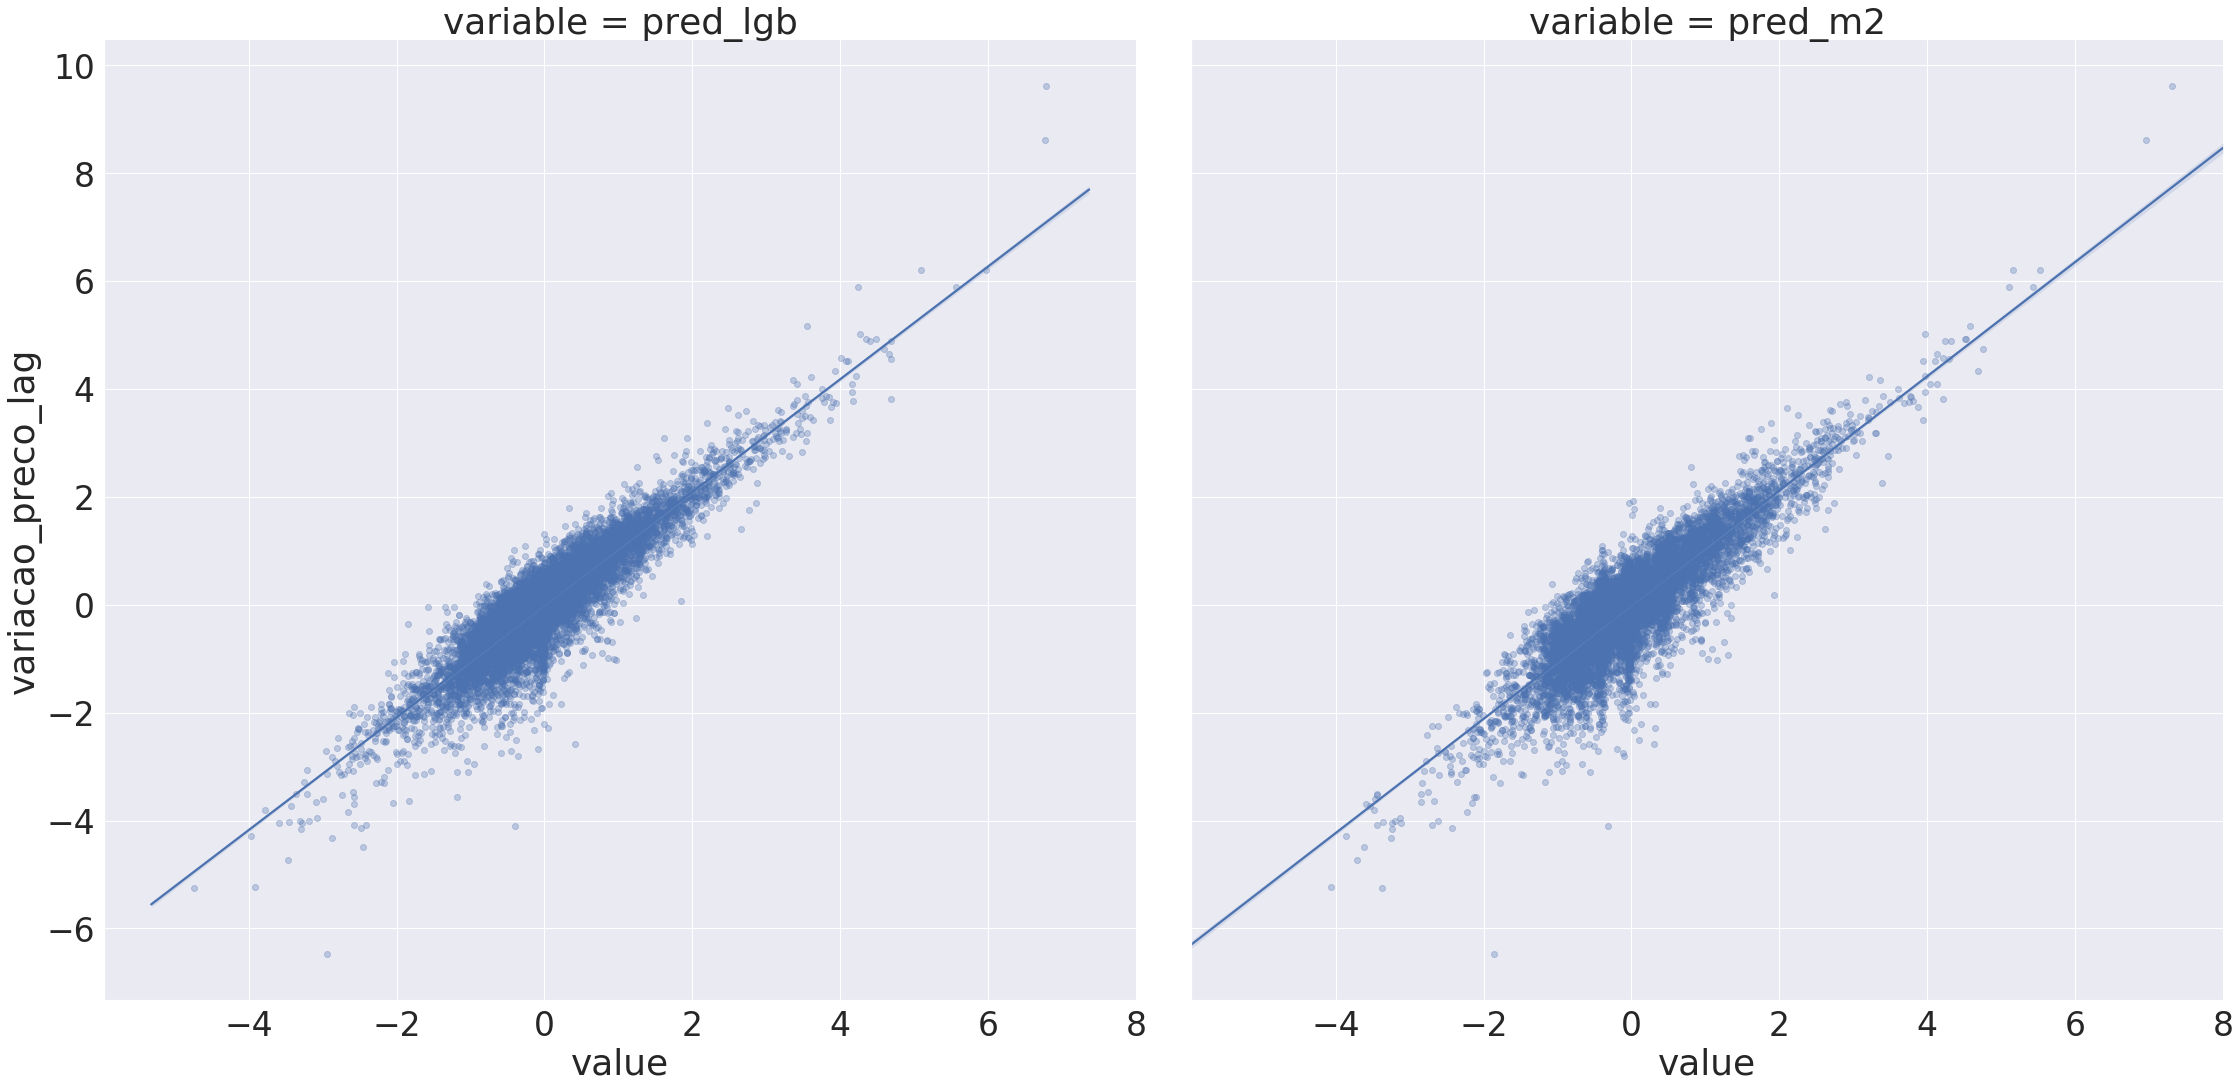

In [84]:
### Plotar scatter com previsão do algoritmo e resultado principal
dados_plot = pd.melt(dados[['variacao_preco_lag','pred_lgb','pred_m2']], 
                       id_vars=['variacao_preco_lag'], 
                       value_vars=['pred_lgb','pred_m2'])

sns.set(font_scale=3)
g = sns.FacetGrid(dados_plot, col="variable", height=16)
g.map(sns.regplot, 'value', 'variacao_preco_lag', scatter_kws={'alpha':0.3})

In [ ]:
dados[['slug', 'variacao_preco_lag', 'predict_m2', 'pred_lbg']].tail(20)